<a href="https://colab.research.google.com/github/taliafabs/STA496/blob/main/Assignment2/code/a2_midterm_modeling_extension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Midterm Paper Extension Assignment: Applying the model to the 2020 Comprehensive Election Study (CES) Dataset

Note: the model was modified slightly to apply to the 2020 CES dataset. The 2020 CES survey does not include a question about perceived price changes in the year leading up to the election, so this economic conditions-related predictor was omitted prior to applying the model to 2020. The outcome variable is now going to be consistently referred to as vote\_incumbent, which is equal to 1 if the respondent voted for the incumbent president's party's nominee and 0 if they voted for the other major party nominee. In the 2024 context, vote\_incumbent is 1 if the respondent voted for Kamala Harris (Democratic nominee; same party as incumbent President Joe Biden) and 0 if they voted for Donald Trump. In the 2020 context, vote\_incumbent is 1 if the respondent voted for Trump (incumbent Republican president) and 0 if they voted for Joe Biden (Democratic nominee).

The model applied to the 2020 dataset is as follows:
\begin{align*}
\texttt{vote_trump} &=  \beta_0 + \beta_1 \cdot \texttt{age_bracket} + \beta_2 \cdot \texttt{gender} + \beta_3 \cdot \texttt{educ} + \beta_4 \cdot \texttt{state} \\
&+ \beta_5 \cdot \texttt{region} + \beta_6 \cdot \texttt{urbancity} + \beta_7 \cdot \texttt{trump_approval} + \beta_8 \cdot \texttt{econ_past_year} \\
&+ \beta_9 \cdot \texttt{family_income_past_year} + \beta_{10} \cdot (\texttt{race $\times$ region}) \\
&+ \beta_{11} \cdot (\texttt{race} \times \texttt{urbancity}) + \beta_{12} \cdot (\texttt{race} \times \texttt{education}) + \beta_{13} \cdot (\texttt{race} \times \texttt{gender})
\end{align*}

The model applied to the 2020 CES dataset is based on the same existing research and likelihood ratio results as the one applied to the 2024 CES dataset in my paper titled "Trump (again): Logistic Regression Analysis of Individual-Level Vote Choice in the 2024 Presidential Election." It builds on the works of Kuriwaki et al., Algara et al., and Camatarri building a logistic regression model that uses both macro- and micro-level predictors to predict individual voting behavior.

Macro-level predictors: incumbent presidential approval (Trump approval in 2020, Biden approval in 2024), economic conditions (perception of the economy, self-reported family income changes, and changes in the price of everyday goods (2024 only) in the year leading up to the election)

Micro-level predictors: age bracket, race, gender, region, state, highest level of educational attainment, interactions between race and gender, race and education, race and region, and race and state.

Whose work suggested the inclusion of what predictors:
* Economy and incumbent presidential approval: Algara
* Race and other demographic (micro-level): Kuriwaki
* Race-related interactions: Kuriwaki
* Combining micro- and macro-level predictors because election results are the culmination of individual vote choices: Camatarri

Note about model application to other datasets:
* Survey questions related to economic conditions vary; therefore the included economic condition predictors will too.

In [1]:
# --- WORKPLACE SETUP ---
# Note: I used ChatGPT to re-format/organize this chunk.

# --- Core Libraries ---
import os
import random
import tempfile

# --- Data Handling ---
import pandas as pd
import numpy as np

# --- Visualization ---
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# --- Stats and Modeling ---
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from scipy.stats.distributions import chi2

# --- Machine Learning ---
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- Deep Learning ---
import tensorflow as tf
from tensorflow import keras
from keras import regularizers

# --- Bayesian Modeling ---
import pymc as pm
import arviz as az

In [2]:
# load the data from drive for now
from google.colab import drive
drive.mount('/content/drive')

# 2024
ces24_data = pd.read_parquet("/content/drive/MyDrive/STA496/Datasets/ces24_clean.parquet")
ces24_dummies = pd.read_parquet("/content/drive/MyDrive/STA496/Datasets/ces24_analysis_dummies.parquet")

# 2020
ces20_data = pd.read_parquet("/content/drive/MyDrive/STA496/Datasets/ces20_clean.parquet")
ces20_dummies = pd.read_parquet("/content/drive/MyDrive/STA496/Datasets/ces20_analysis_dummies.parquet")

Mounted at /content/drive


## 2024 CES Dataset

\begin{align*}
\texttt{vote_harris} &=  \beta_0 + \beta_1 \cdot \texttt{age_bracket} + \beta_2 \cdot \texttt{gender} + \beta_3 \cdot \texttt{educ} + \beta_4 \cdot \texttt{state} \\
&+ \beta_5 \cdot \texttt{region} + \beta_6 \cdot \texttt{urbancity} + \beta_7 \cdot \texttt{biden_approval} + \beta_8 \cdot \texttt{econ_past_year} \\
&+ \beta_9 \cdot \texttt{family_income_past_year} + \beta_{10} \cdot (\texttt{race $\times$ region}) \\
&+ \beta_{11} \cdot (\texttt{race} \times \texttt{urbancity}) + \beta_{12} \cdot (\texttt{race} \times \texttt{education}) + \beta_{13} \cdot (\texttt{race} \times \texttt{gender})
\end{align*}

In [3]:
# logistic model on the 2024 ces dummies (same as in midterm paper except for price_change_past_year)
train_dataset = ces24_dummies.sample(frac=0.75, random_state=0)
test_dataset = ces24_dummies.drop(train_dataset.index)

X_train, y_train = train_dataset.drop('vote_incumbent', axis=1), train_dataset['vote_incumbent']
X_test, y_test = test_dataset.drop('vote_incumbent', axis=1), test_dataset['vote_incumbent']

In [4]:
# define the logistic model architecture (extremely similar to midterm paper)
logistic_model = keras.Sequential([
    keras.layers.Dense(1,
                       activation='sigmoid',
                       input_shape=(X_train.shape[1],),
                       kernel_regularizer = regularizers.l2(0.001) # l2 regularization and lambda penalty
                       )
])

# compile model SGD, learning rate 0.01, batch size 32, 100 epochs
logistic_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), # learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# fit it
history = logistic_model.fit(X_train, y_train,
                             epochs=50, # reduce number of epochs from midterm paper
                             batch_size=32,
                             validation_data=(X_test, y_test),
                             verbose=0)

y_pred_prob = logistic_model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)
print(classification_report(y_test, y_pred, digits=4)) # round this to 4 decimal places

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
              precision    recall  f1-score   support

           0     0.9082    0.9226    0.9154      4911
           1     0.9408    0.9295    0.9351      6498

    accuracy                         0.9265     11409
   macro avg     0.9245    0.9261    0.9252     11409
weighted avg     0.9268    0.9265    0.9266     11409



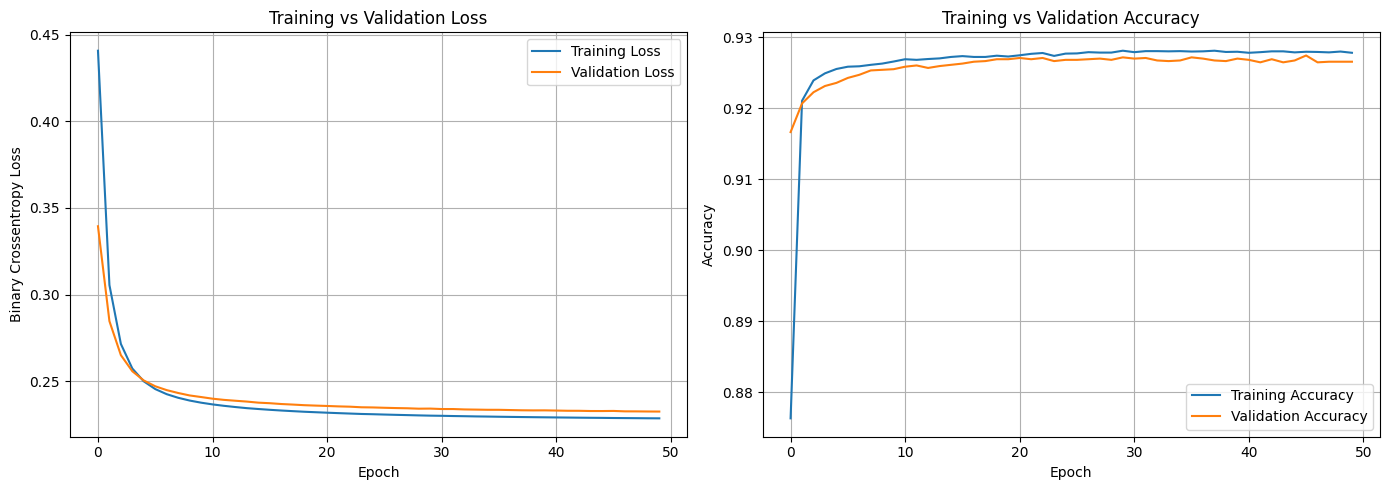

In [6]:
# I asked chatgpt how to plot training and validation accuracy side by side

# Create 1 row, 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# --- Loss Plot ---
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Binary Crossentropy Loss')
axs[0].set_title('Training vs Validation Loss')
axs[0].legend()
axs[0].grid(True)

# --- Accuracy Plot ---
axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training vs Validation Accuracy')
axs[1].legend()
axs[1].grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

## 2020 CES dataset

\begin{align*}
\texttt{vote_trump} &=  \beta_0 + \beta_1 \cdot \texttt{age_bracket} + \beta_2 \cdot \texttt{gender} + \beta_3 \cdot \texttt{educ} + \beta_4 \cdot \texttt{state} \\
&+ \beta_5 \cdot \texttt{region} + \beta_6 \cdot \texttt{urbancity} + \beta_7 \cdot \texttt{trump_approval} + \beta_8 \cdot \texttt{econ_past_year} \\
&+ \beta_9 \cdot \texttt{family_income_past_year} + \beta_{10} \cdot (\texttt{race $\times$ region}) \\
&+ \beta_{11} \cdot (\texttt{race} \times \texttt{urbancity}) + \beta_{12} \cdot (\texttt{race} \times \texttt{education}) + \beta_{13} \cdot (\texttt{race} \times \texttt{gender})
\end{align*}

In [7]:
train20 = ces20_dummies.sample(frac=0.75, random_state=0)
test20 = ces20_dummies.drop(train20.index)
X_train20, y_train20 = train20.drop('vote_incumbent', axis=1), train20['vote_incumbent']
X_test20, y_test20 = test20.drop('vote_incumbent', axis=1), test20['vote_incumbent']

In [8]:
# train and apply model to 2020 data
logistic_model = keras.Sequential([
    keras.layers.Dense(1,
                       activation='sigmoid',
                       input_shape=(X_train20.shape[1],),
                       kernel_regularizer = regularizers.l2(0.001) # l2 regularization and lambda penalty
                       )
])

# compile model SGD, learning rate 0.01, batch size 32, 100 epochs
logistic_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), # learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# fit it
history = logistic_model.fit(X_train20, y_train20,
                             epochs=50, # reduce number of epochs
                             batch_size=32,
                             validation_data=(X_test20, y_test20),
                             verbose=0)

y_pred_prob = logistic_model.predict(X_test20)
y_pred20 = (y_pred_prob >= 0.5).astype(int)
print(classification_report(y_test20, y_pred20, digits=4)) # round this to 4 decimal places


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0     0.9821    0.9593    0.9706      6536
           1     0.9415    0.9740    0.9575      4392

    accuracy                         0.9652     10928
   macro avg     0.9618    0.9667    0.9640     10928
weighted avg     0.9658    0.9652    0.9653     10928



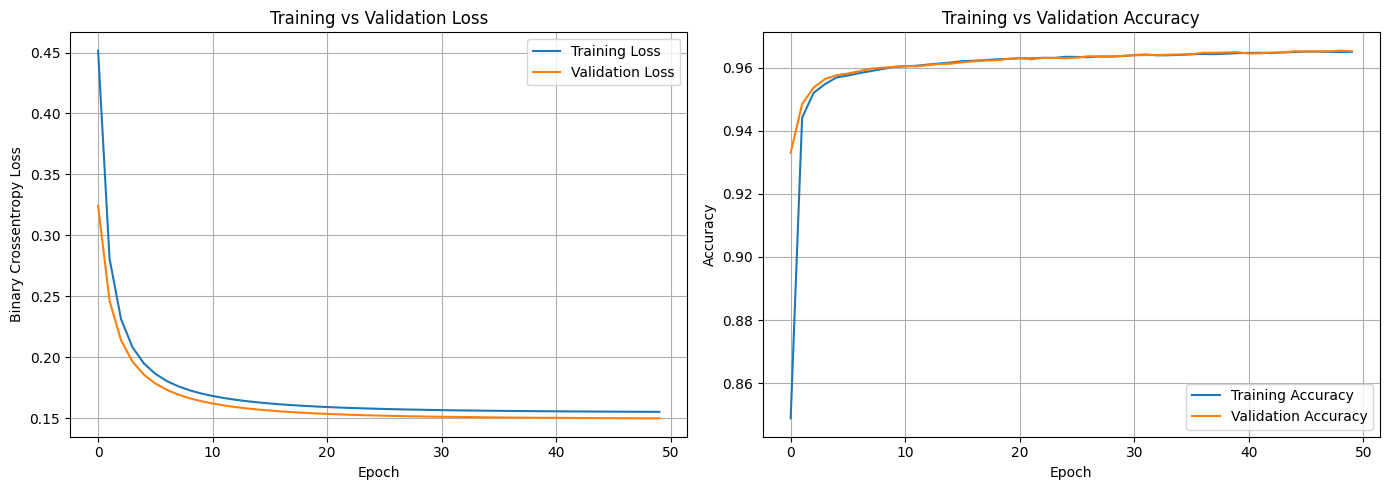

In [9]:
# Create 1 row, 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# --- Loss Plot ---
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Binary Crossentropy Loss')
axs[0].set_title('Training vs Validation Loss')
axs[0].legend()
axs[0].grid(True)

# --- Accuracy Plot ---
axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training vs Validation Accuracy')
axs[1].legend()
axs[1].grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

**Performance on the 2020 CES Dataset**
The model achieved 96.52% validation accuracy the 2020 CES dataset. This is even higher than its validation accuracy on the 2024 CES dataset (92.8% with the `price_change_past_year` predictor, 92.65% using the exact same predictors as the model applied to the 2020 dataset).

This demonstrates that the model is highly capable of classifying survey respondents who voted for the Democratic and Republican nominee. Gives me increased confidence that it can be used as part of a larger forecasting project. Individual-level factors such as age, race, gender, highest level of educational attainment, state, and the urban-rural divide are known to influence voting behavior, but national-level factors such as the popularity (or lack thereof) of the incumbent president and economic conditions also influence voting behavior. This model includes both; this likely contributes to its strong classification performance. The same modeling strategy achieved high validation accuracy on survey datasets from two different election cycles.